# Approximate Optimality

This notebook contains the analysis corresponding to the "Approximate Optimality" section of the paper. We prepare code to identify scale factors, identify the approximate optimal solutions, and then create the figures that go into the paper. 

## Load Data and Packages

In [1]:
import sys
import os
from scipy.io import loadmat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
%matplotlib inline

In [2]:
from matplotlib import colorbar
from matplotlib.colors import Normalize

In [3]:
from itertools import product

In [4]:
plt.rcParams['figure.figsize'] = [20, 12]
sns.set_style('whitegrid')
plt.rcParams['font.size'] = 36.0
plt.rcParams['xtick.labelsize'] = 36.0
plt.rcParams['ytick.labelsize'] = 36.0

In [34]:
def plt_savefig_safe(savepath):
    '''
    Makes a new folder with the savepath directory, if it does not exist. 
    Then, saves the figure via matplotlib.
    
    savepath: string that gives the filepath we want to save a figure to.
    We take the deepest folder it's in and check if that directory exists. 
    '''
    index_of_last_slash = savepath.rfind('/')
    savedir = savepath[:index_of_last_slash + 1]

    directory = os.path.dirname(savedir)

    if not os.path.exists(directory):
        os.makedirs(directory)

    plt.savefig(savepath)

In [5]:
# Load allocation dataframes. 

one_fac_replace_ab_df = pd.read_csv('all-data/allocation-dfs/one_fac_replace_alta_bates_with_replacement.csv')
one_fac_replace_ab_no_replacement_df = pd.read_csv('all-data/allocation-dfs/one_fac_replace_alta_bates_no_replacement.csv')

In [6]:
two_facs_df = pd.read_csv('all-data/allocation-dfs/two_facs_to_open_from_scratch.csv')
three_facs_df = pd.read_csv('all-data/allocation-dfs/three_facs_to_open_from_scratch.csv')

In [7]:
DATA_PATH = 'all-data/'
# Load tract-facility distance matrix, computed via the Google Maps API. 
# Distances refer to the driving distance between pairs of locations. 
gmaps_distance_matrix = pd.read_csv(DATA_PATH + 'all_travel_distance_matrix.csv')

# Remove unnecessary first column.
gmaps_distance_matrix = gmaps_distance_matrix.iloc[:, 1:].copy()

# Convert to numpy array, and divide by 1000 to convert meters to kilometers. 
tract_facility_distance_matrix = np.array(gmaps_distance_matrix)[:, :] / 1000.0

In [8]:
race_split_df_all = pd.read_csv(DATA_PATH + 'census-datasets/combined-al-cc/ethnicity_split_all.csv')
health_ins_split_df_all = pd.read_csv(DATA_PATH + 'census-datasets/combined-al-cc/health_ins_split_all.csv')
income_split_df_all = pd.read_csv(DATA_PATH + 'census-datasets/combined-al-cc/income_split_all.csv')

# Equity Metric Rescaling


In order to have a consistent notion of equity weight, we need all of our equity metrics to be on roughly the same order of magnitude. Otherwise, an equity weight of $\lambda = 10$ might mean drastically more weight in the context of one equity metric than another, which would invalidate seeking to find approximately optimal solutions for a fixed $\lambda$. 

There are two considerations here. 

1. Aggregation type. If using averaging, then we should use average individual distance as the "vanilla" portion of the objective. If using summing, then we should instead use the total individual distance. 

2. The Gini coefficient is always in $[0, 1]$. Since the denominator is just the sum of group effects, we need a correction factor for the Gini coefficient metric which is independent of the particular allocation (so it does not skew the optimization), but still is of the same rough order of magnitude. So, we'll just use the mean distance from a census tract to a hospital. 

If using averaging, then this is enough of a factor. But when using summing, we should always scale by the total population, so that the metric has the same rough order of magntiude as total travel distance. 

In [9]:
three_facs_df.head()

,Unnamed: 0,Facs_To_Open,Total_Indiv_Dist,Mean_Indiv_Dist,NH_AIAN_alone_ACS_10_14_Sum,NH_AIAN_alone_ACS_10_14_Avg,NH_Asian_alone_ACS_10_14_Sum,NH_Asian_alone_ACS_10_14_Avg,NH_Blk_alone_ACS_10_14_Sum,NH_Blk_alone_ACS_10_14_Avg,...,Metric_3_Sum_Health_Ins,Metric_3_Avg_Race,Metric_3_Avg_Income,Metric_3_Avg_Health_Ins,Metric_5_Sum_Race,Metric_5_Sum_Income,Metric_5_Sum_Health_Ins,Metric_5_Avg_Race,Metric_5_Avg_Income,Metric_5_Avg_Health_Ins
0,0,"[0, 1, 2]",7.365147e+07,27.892578,160120.827070,21.720473,1.436382e+07,25.248278,4.311818e+06,14.783529,...,2.502012e+07,37.561066,5.897632,6.334305,0.556636,0.404076,0.169855,0.148996,0.057506,0.054119
1,1,"[0, 1, 3]",7.283682e+07,27.584061,157243.841984,21.330208,1.411927e+07,24.818408,4.109572e+06,14.090107,...,2.443644e+07,38.707998,5.927159,6.550085,0.558058,0.404434,0.167748,0.155345,0.058524,0.056468
2,2,"[0, 1, 4]",7.344911e+07,27.815945,158813.389070,21.543118,1.430199e+07,25.139592,4.271214e+06,14.644315,...,2.487118e+07,37.912232,5.930825,6.391589,0.556748,0.404261,0.169309,0.150752,0.058032,0.054729
3,3,"[0, 1, 5]",5.949877e+07,22.532805,99535.731920,13.502073,7.477388e+06,13.143521,3.039724e+06,10.422020,...,1.446774e+07,55.202274,4.142315,10.466853,0.568647,0.401205,0.121580,0.242625,0.049431,0.105538
4,4,"[0, 1, 6]",5.831517e+07,22.084563,97901.273061,13.280358,6.755647e+06,11.874868,3.512837e+06,12.044140,...,1.303410e+07,55.333858,2.951643,11.325712,0.558729,0.395985,0.111756,0.240417,0.035211,0.115421


Total population is calculated in `allocation_df_prepare.ipynb`. We'll just hardcode it here to save time. 

In [10]:
TOTAL_POPULATION = 2640540.0

In [11]:
mean_dist_to_hospital = np.mean(tract_facility_distance_matrix)

In [12]:
def gini_scale_factor(num_facs_opened, averaging=True): 
    factor = mean_dist_to_hospital * num_facs_opened
    if averaging: 
        return factor
    else: 
        return (factor * TOTAL_POPULATION)

Let's look at the distribution of these rescaled Gini coefficients versus other equity metrics, as well as the total distance, across all openings of three facilities. 

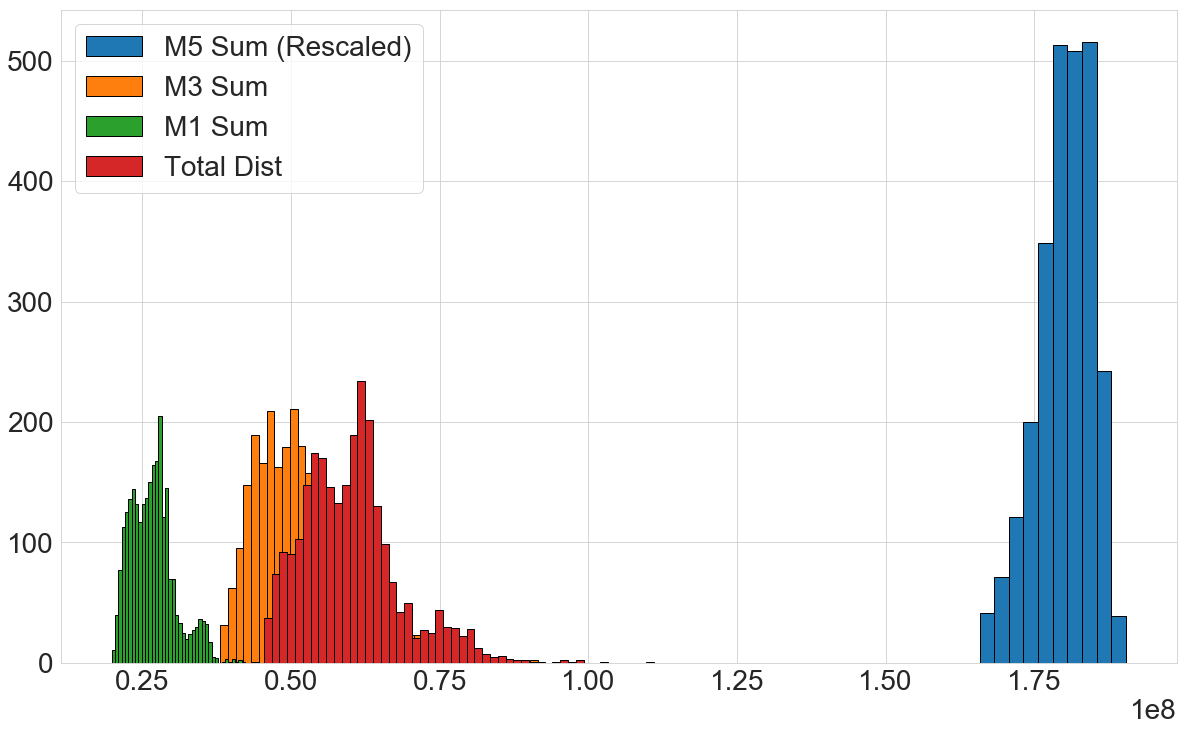

In [29]:
plt.hist(three_facs_df['Metric_5_Sum_Race'] * gini_scale_factor(3, averaging=False), bins=10, ec='k', label='M5 Sum (Rescaled)')
plt.hist(three_facs_df['Metric_3_Sum_Race'], bins=50, ec='k', label='M3 Sum')
plt.hist(three_facs_df['Metric_1_Sum_Race'], bins=50, ec='k', label='M1 Sum')
plt.hist(three_facs_df['Total_Indiv_Dist'], bins=50, ec='k', label='Total Dist');
plt.legend();
plt.savefig('visualizations/misc/metric-orders-of-magnitude-summing.png');

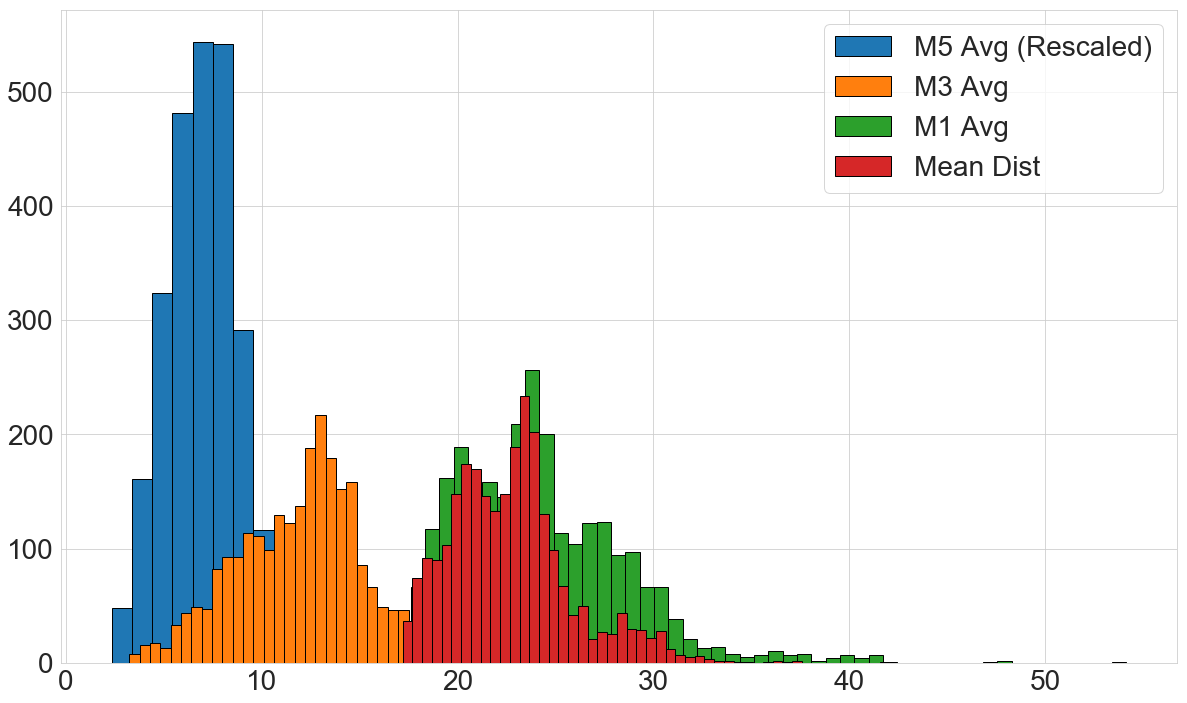

In [30]:
plt.hist(three_facs_df['Metric_5_Avg_Race'] * gini_scale_factor(3, averaging=True), bins=10, ec='k', label='M5 Avg (Rescaled)')
plt.hist(three_facs_df['Metric_3_Avg_Race'], bins=50, ec='k', label='M3 Avg')
plt.hist(three_facs_df['Metric_1_Avg_Race'], bins=50, ec='k', label='M1 Avg')
plt.hist(three_facs_df['Mean_Indiv_Dist'], bins=50, ec='k', label='Mean Dist');
plt.legend();
plt.savefig('visualizations/misc/metric-orders-of-magnitude-averaging.png');

It turns out that for summing, the values are a bit large, and for averaging, they are a bit smaller than we would like. But given the difference in distirbution of M3 and M1 already, the scale difference is not too bad. We are just trying to achieve the same order of magnitude here. For consistency's sake, we'll maintain this scale factor for all approximate optimality calculations. 

## Setup Functions

In [13]:
def get_df_filter_facs(df_with_metrics, exclude_facs): 
    '''
    Helper function designed to return a subset of the possible allocations, 
    when we want to restrict attention to some subset of them. 
    
    df_with_metrics: An allocations dataframe, in Pandas. 
    exclude_facs: list of integers, which we don't include in the df.
    '''
    if exclude_facs == []: 
        return df_with_metrics
    
    # Filter out allocations which include facilities we want to exclude
    def contains_excluded_facs(facs_to_open_str): 
        for fac_num in exclude_facs: 
            if str(fac_num) in facs_to_open_str: 
                return True
        return False
    
    cur_df = df_with_metrics[df_with_metrics['Facs_To_Open'].apply(contains_excluded_facs) == False]
    return cur_df

In [14]:
def get_optimal_allocs(df_with_metrics, lambda_vals = [0.0, 1.0], 
                       eta_vals = [0.0, 1.0], exclude_facs = []): 
    '''
    Returns a dictionary whose keys are different configurations of the objective function,
    and values are the subsets of facilities which are optimal for each respective configuration. 
    
    df_with_metrics: An allocations dataframe, in Pandas.
    lambda_vals: List or 1D array of floats. The values of lambda (equity weight) to test. 
    eta_vals: List or 1D array of floats. The values of eta (capacity excess weight) to test. 
    exclude_facs: list of integers, denoting the IDs of facilities which are not included as options. 
    '''
    metric_col_names = [col_name for col_name in df_with_metrics.columns.values if 'Metric' in col_name]
    num_facs_opened = len(df_with_metrics['Facs_To_Open'].iloc[0].split(','))
    
    cur_df = get_df_filter_facs(df_with_metrics, exclude_facs)
    
    best_allocs_dict = {}
    for lambda_val, eta_val in product(lambda_vals, eta_vals):     
        for col in metric_col_names: 
            if 'Metric_5_Avg' in col: 
                objective_val = cur_df['Mean_Indiv_Dist'] +\
                                lambda_val * gini_scale_factor(num_facs_opened, averaging=True) * cur_df[col] +\
                                (eta_val/TOTAL_POPULATION) * cur_df['Capacity_Excess']
            elif 'Metric_5_Sum' in col: 
                objective_val = cur_df['Mean_Indiv_Dist'] +\
                                lambda_val * gini_scale_factor(num_facs_opened, averaging=False) * cur_df[col] +\
                                eta_val * cur_df['Capacity_Excess']
            elif 'Sum' in col: 
                objective_val = cur_df['Total_Indiv_Dist'] +\
                                lambda_val * cur_df[col] +\
                                eta_val * cur_df['Capacity_Excess']
            elif 'Avg' in col: 
                objective_val = cur_df['Mean_Indiv_Dist'] +\
                                lambda_val * cur_df[col] +\
                                (eta_val/TOTAL_POPULATION) * cur_df['Capacity_Excess']
            else:
                assert False, '{} does not have Avg or Sum in its name. How is this a column?'.format(col)
            best_alloc_index = np.argmin(np.array(objective_val))
            best_alloc_facs = cur_df.iloc[best_alloc_index]['Facs_To_Open']
            
            dict_key = '{}_Lambda_{}_Eta_{}'.format(col, lambda_val, eta_val)
            best_allocs_dict[dict_key] = best_alloc_facs
    return best_allocs_dict

Let's test this function on our actual dataframe to see if it makes sense. 

In [15]:
get_optimal_allocs(three_facs_df)

{'Metric_1_Sum_Race_Lambda_0.0_Eta_0.0': '[10, 11, 23]',
 'Metric_1_Sum_Income_Lambda_0.0_Eta_0.0': '[10, 11, 23]',
 'Metric_1_Sum_Health_Ins_Lambda_0.0_Eta_0.0': '[10, 11, 23]',
 'Metric_1_Avg_Race_Lambda_0.0_Eta_0.0': '[10, 11, 23]',
 'Metric_1_Avg_Income_Lambda_0.0_Eta_0.0': '[10, 11, 23]',
 'Metric_1_Avg_Health_Ins_Lambda_0.0_Eta_0.0': '[10, 11, 23]',
 'Metric_3_Sum_Race_Lambda_0.0_Eta_0.0': '[10, 11, 23]',
 'Metric_3_Sum_Income_Lambda_0.0_Eta_0.0': '[10, 11, 23]',
 'Metric_3_Sum_Health_Ins_Lambda_0.0_Eta_0.0': '[10, 11, 23]',
 'Metric_3_Avg_Race_Lambda_0.0_Eta_0.0': '[10, 11, 23]',
 'Metric_3_Avg_Income_Lambda_0.0_Eta_0.0': '[10, 11, 23]',
 'Metric_3_Avg_Health_Ins_Lambda_0.0_Eta_0.0': '[10, 11, 23]',
 'Metric_5_Sum_Race_Lambda_0.0_Eta_0.0': '[10, 11, 23]',
 'Metric_5_Sum_Income_Lambda_0.0_Eta_0.0': '[10, 11, 23]',
 'Metric_5_Sum_Health_Ins_Lambda_0.0_Eta_0.0': '[10, 11, 23]',
 'Metric_5_Avg_Race_Lambda_0.0_Eta_0.0': '[10, 11, 23]',
 'Metric_5_Avg_Income_Lambda_0.0_Eta_0.0': '[10,

Next let's create a function to rename our metrics to something readable for figures.

In [16]:
def metric_name_to_readable_name(metric_name): 
    out = ''
    if 'Metric_1' in metric_name: 
        out += 'Min-Max '
    elif 'Metric_3' in metric_name: 
        out += 'Mean Abs. Dev. '
    elif 'Metric_5' in metric_name: 
        out += 'Gini Coeff.'
    if 'Income' in metric_name: 
        out += 'Income '
    elif 'Health_Ins' in metric_name: 
        out += 'Health Ins. '
    elif 'Race' in metric_name: 
        out += 'Ethnicity '
    
    if 'Sum' in metric_name: 
        out += 'Summed'
    elif 'Avg' in metric_name: 
        out += 'Averaged'
    return out

In [17]:
metric_col_names = [name for name in two_facs_df.columns.values if 'Metric' in name]
print([metric_name_to_readable_name(name) for name in metric_col_names])

['Min-Max Ethnicity Summed', 'Min-Max Income Summed', 'Min-Max Health Ins. Summed', 'Min-Max Ethnicity Averaged', 'Min-Max Income Averaged', 'Min-Max Health Ins. Averaged', 'Mean Abs. Dev. Ethnicity Summed', 'Mean Abs. Dev. Income Summed', 'Mean Abs. Dev. Health Ins. Summed', 'Mean Abs. Dev. Ethnicity Averaged', 'Mean Abs. Dev. Income Averaged', 'Mean Abs. Dev. Health Ins. Averaged', 'Gini Coeff.Ethnicity Summed', 'Gini Coeff.Income Summed', 'Gini Coeff.Health Ins. Summed', 'Gini Coeff.Ethnicity Averaged', 'Gini Coeff.Income Averaged', 'Gini Coeff.Health Ins. Averaged']


Next, let's create a function to compute scale factors for every equity metric, for every allocation. 

In [18]:
def compute_all_scale_facs_from_df(df_with_metrics, include_vanilla = True, 
                                   lambda_val = 1.0, eta_val = 1.0): 
    '''
    INPUT:
    df_with_metrics: Pandas dataframe with equity metric values for all allocations
    include_vanilla: Whether to also include the mean individual distance (the "vanilla objective")
    with the calculations, or not.
    lambda_val: The equity weight to include for all equity metrics.
    eta_val: The capacity excess weight to include for every allocation. 
    
    OUTPUT:
    A matrix whose rows correspond to facility openings, and columns
    correspond to the scale factor of an objective value for that row. 
    '''
    metric_col_names = [col_name for col_name in df_with_metrics.columns.values if 'Metric' in col_name]
    num_facs_opened = len(df_with_metrics['Facs_To_Open'].iloc[0].split(','))
    
    objective_vals_arr = []
    if include_vanilla:
        dist_array = np.array(df_with_metrics['Mean_Indiv_Dist']) / np.min(df_with_metrics['Mean_Indiv_Dist'])
        objective_vals_arr.append(dist_array)
    
    cur_df = df_with_metrics
    for col in metric_col_names: 
        if 'Metric_5_Avg' in col: 
            objective_val = cur_df['Mean_Indiv_Dist'] +\
                            lambda_val * gini_scale_factor(num_facs_opened, averaging=True) * cur_df[col] +\
                            (eta_val/TOTAL_POPULATION) * cur_df['Capacity_Excess']
        elif 'Metric_5_Sum' in col: 
            objective_val = cur_df['Mean_Indiv_Dist'] +\
                            lambda_val * gini_scale_factor(num_facs_opened, averaging=False) * cur_df[col] +\
                            eta_val * cur_df['Capacity_Excess']
        elif 'Sum' in col: 
            objective_val = cur_df['Total_Indiv_Dist'] +\
                            lambda_val * cur_df[col] +\
                            eta_val * cur_df['Capacity_Excess']
        elif 'Avg' in col: 
            objective_val = cur_df['Mean_Indiv_Dist'] +\
                            lambda_val * cur_df[col] +\
                            (eta_val/TOTAL_POPULATION) * cur_df['Capacity_Excess']
        else:
            assert False, '{} does not have Avg or Sum in its name. How is this a column?'.format(col)
        objective_vals_arr.append(np.array(objective_val) / min(objective_val))
    return np.vstack(objective_vals_arr).T

Again, let's test this function.

In [19]:
test_out = compute_all_scale_facs_from_df(three_facs_df)

In [20]:
print(test_out.shape, three_facs_df.shape)

(2600, 19) (2600, 43)


In [21]:
type(test_out)

numpy.ndarray

In [22]:
test_out[0]

array([1.62162346, 1.64443596, 1.63121148, 1.63255247, 1.69576658,
       1.63106309, 1.67025455, 1.6751739 , 1.63639058, 1.64098323,
       2.7205568 , 1.73733406, 1.84427604, 1.1311645 , 1.11458255,
       1.92300049, 1.94545545, 1.7351469 , 1.82383781])

# Scale Factor Heatmap

In [58]:
def get_row_indices(scale_facs_matrix, use_cols_subset = None): 
    '''
    Returns indices of the rows in a scale factor matrix which correspond to the approximately optimal 
    (what we called "pareto") solution, and the optimal solution for each individual objective. 
    
    scale_facs_matrix: 2D array of scale factors. Usually output of "compute_all_scale_facs_from_df"
    use_cols_subset: List of integers corresponding to which subset of the columns to use when getting output. 
    Each column corresponds to a different objective function configuration. If None, uses all columns. 
    '''
    if type(use_cols_subset) != type(None): 
        sub_matrix = scale_facs_matrix[:, use_cols_subset]
        pareto_with_vanilla_index = np.argmin(np.max(sub_matrix, axis=1))
        pareto_without_vanilla_index = np.argmin(np.max(sub_matrix[:, 1:], axis=1))
    else:
        pareto_with_vanilla_index = np.argmin(np.max(scale_facs_matrix, axis=1))
        pareto_without_vanilla_index = np.argmin(np.max(scale_facs_matrix[:, 1:], axis=1))
        
    indices = []
    
    for i in range(len(scale_facs_matrix[0])): 
        best_index_metric_i = np.argmin(scale_facs_matrix[:, i])
        indices.append(best_index_metric_i)

    indices.append(pareto_with_vanilla_index)
    return indices

In [59]:
scale_facs = compute_all_scale_facs_from_df(three_facs_df, lambda_val=10, eta_val=0)

In [60]:
scale_facs.shape

(2600, 19)

In [84]:
def make_best_allocs_heatmap(scale_facs_matrix, df_with_metrics, row_indices, 
                             cur_lambda, cur_eta, keep_approx_optimal_row = False, 
                             savepath = None, annotate=True): 
    '''
    Creates a heatmap of the scale factors of each optimal allocation with respect to every objective.
    
    INPUT: 
    scale_facs_matrix: A matrix whose rows are facility openings and columns are scale factors
    for that opening with respect to a particular metric. 
    
    df_with_metrics: The Pandas DF with raw effects and equity metric values 
    row_indices: Indices of the facility openings we want to display the rows for. Each index
    in this list will give a row of the heatmap. By convention, the bottom index corresponds to 
    the approximately optimal solution (see `get_row_indices`). 
    cur_lambda: The lambda value (equity weight) which produced all of these scale factors.
    cur_eta: The eta value (capacity excess weight) which produced all of these scale factors.
    savepath: Filepath where the plot will be saved as png. 
    annotate: Boolean. Whether to annotate the heatmap with the numeric value in each cell. 
    keep_approx_optimal_row: Boolean. Whether to include the approximately optimal solution when displaying
    the scale factors. This is the bottom row of the heatmap, if included. 
    '''
    facs_to_open_list = list(df_with_metrics['Facs_To_Open'].iloc[row_indices])
    row_labels = list(np.arange(len(row_indices) - 1))
    col_labels = ['M{}'.format(x) for x in row_labels]
    
    if keep_approx_optimal_row: 
        # Put the approx optimal row on the bottom. 
        new_row_indices = [x for x in row_indices]
        row_labels.append('*')
    else:
        # Ignore the first index, which is the approx. optimal solution.
        new_row_indices = [row_indices[i] for i in range(len(row_indices) - 1)]
        
    ax = sns.heatmap(scale_facs_matrix[new_row_indices], 
                cmap='viridis', annot=annotate, fmt='.1f',
                xticklabels=col_labels, yticklabels=row_labels)
    
    #     plt.xlabel('Scale Factor for Each Composite Objective')
    ax.set_ylabel('Objective for which optimal allocation is computed')
    if keep_approx_optimal_row: 
        ax.hlines([len(row_labels) - 1], *ax.get_xlim(), colors = 'w', linewidth = 5)
    
    plt.tight_layout()
    
    if savepath: 
        plt_savefig_safe(savepath)
    else:
        plt.show()
    plt.close()

Let's examine some of these scale factor heatmaps when opening three facilities from scratch. 

In [85]:
plt.rcParams['font.size'] = 30

In [86]:
cur_lambda = 10.0
cur_eta = 0.0
# savepath_str = None
savepath_str = 'visualizations/approx-optimality/scale-factor-heatmaps/three-facs-to-open/' +\
                        'scale_facs_three_facs_lambda_{}_eta_{}.png'.format(int(cur_lambda), int(cur_eta))
scale_facs = compute_all_scale_facs_from_df(three_facs_df, lambda_val=cur_lambda, eta_val=cur_eta)
make_best_allocs_heatmap(scale_facs, three_facs_df, get_row_indices(scale_facs), cur_lambda, cur_eta,
                         keep_approx_optimal_row=True, savepath=savepath_str, annotate=True)

In [87]:
plt.rcParams['font.size'] = 36

Let's create these heatmaps for a range of $\lambda$ values. 

In [88]:
for i in range(0, 8): 
    if i != 1: 
        print(10**i)
        cur_lambda = 10 ** i
        cur_eta = 0.0
        savepath_str = 'visualizations/approx-optimality/scale-factor-heatmaps/three-facs-to-open/' +\
                                'scale_facs_three_facs_lambda_{}_eta_{}.png'.format(int(cur_lambda), int(cur_eta))
        scale_facs = compute_all_scale_facs_from_df(three_facs_df, lambda_val=cur_lambda, eta_val=cur_eta)
        make_best_allocs_heatmap(scale_facs, three_facs_df, get_row_indices(scale_facs), cur_lambda, cur_eta,
                                 keep_approx_optimal_row=True, savepath=savepath_str, annotate=False)

1
100
1000
10000
100000
1000000
10000000


# Worst Scale Factor vs Lambda

Once we have the approximately optimal solution, its worst scale factor can be interpreted as a lower bound on the amount of agreement it is possible to achieve amongst the various configurations of equity in a problem. Thus, it is of interest to understand the relationship between the value of $\lambda$ (the equity weight) and the worst scale factor of the approximately optimal allocation. 

In [30]:
from collections import OrderedDict

In [31]:
def get_cmap(n, name='Paired'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

In [32]:
def get_worst_scale_facs_vs_lambda(df_with_metrics, LAMBDA_VALS, eta_val, include_vanilla=True): 
    '''
    Returns 2 1D arrays, giving the worst scale factor of the approximately optimal solution, 
    for each value of Lambda, and the index corresponding to that approximately optimal solution. 
    
    df_with_metrics: The Pandas DF with raw effects and equity metric values 
    LAMBDA_VALS: List or 1D array of floats, giving the lambda values (equity weights) to test. 
    in this list will give a row of the heatmap. 
    eta_val: The eta value (capacity excess weight) to apply in every case. 
    include_vanilla: Boolean. Whether or not to include the vanilla objective when computing scale factors 
    for the various allocations. 
    '''
    
    scale_fac_values = []
    scale_fac_indices = []
    for lambda_val in LAMBDA_VALS: 
        scale_facs_matrix = compute_all_scale_facs_from_df(df_with_metrics, 
                                                          include_vanilla=include_vanilla, 
                                                          lambda_val = lambda_val, eta_val = eta_val)
        worst_scale_factor = np.min(np.max(scale_facs_matrix, axis=1))
        worst_scale_fac_index = np.argmin(np.max(scale_facs_matrix, axis=1))
        
        scale_fac_values.append(worst_scale_factor)
        scale_fac_indices.append(worst_scale_fac_index)
    return np.array(scale_fac_values), np.array(scale_fac_indices)

In [42]:
def plot_worst_scale_facs_vs_lambda(df_with_metrics, LAMBDA_VALS, 
                                      eta_val = 0.0,  
                                      include_vanilla = True,
                                      savepath = None):
    
    scale_fac_values, scale_fac_indices = get_worst_scale_facs_vs_lambda(df_with_metrics, 
                                                                         LAMBDA_VALS, eta_val, 
                                                                         include_vanilla=include_vanilla)
    
    # Set up unique allocation numbers and values for plotting. 
    uq_pareto_best_indices = list(set(scale_fac_indices))
    num_unique_allocs = len(uq_pareto_best_indices)
    uq_facs_to_open = list(df_with_metrics['Facs_To_Open'].iloc[uq_pareto_best_indices])
    cmap = get_cmap(num_unique_allocs)
    markers_list = ['o', '^', '*', 's', '8', 'p', 'P']
    
    for i in range(len(LAMBDA_VALS)): 
        current_allocation_index = scale_fac_indices[i]
        cur_facs_to_open = df_with_metrics.iloc[current_allocation_index]['Facs_To_Open']
        current_index_relative_numbering = uq_pareto_best_indices.index(current_allocation_index)
        
        cur_color = cmap(current_index_relative_numbering)
        cur_marker = markers_list[current_index_relative_numbering % len(markers_list)]

        
        plt.scatter(LAMBDA_VALS[i], scale_fac_values[i], marker = cur_marker,
                    c = [cur_color], s=200) #label='Facilities {}'.format(cur_facs_to_open))
    
    # Create legend, remove duplicate labels
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    #     plt.legend(by_label.values(), by_label.keys())
    
    
    plt.xscale('log')
    plt.ylabel('Scale Factor of Approx. Optimum')
    plt.xlabel('Lambda Value in Additive Objective (Log-Scaled)')
    
    if savepath: 
        plt.savefig(savepath)
    else: 
        plt.show()
    plt.close()

In [43]:
plt.rcParams['font.size'] = 36

In [44]:
%%time
save_path_str = 'visualizations/approx-optimality/lambda_vs_worst_scale_fac_three_facs_from_scratch.png'
# save_path_str = None
plot_worst_scale_facs_vs_lambda(three_facs_df, np.logspace(-1, 10, 400), 
                                savepath=save_path_str)

CPU times: user 11.3 s, sys: 121 ms, total: 11.4 s
Wall time: 11.6 s


# Optimal Allocations Across Equity Metric, Lambda, Eta

The approximate optimality factor gives a numerical measure of agreement levels between the various equity metrics. However, it does not tell us which equity measures actually agree, and how often. A simple way of doing this is to look at which allocation is optimal under various such configurations. 

In [47]:
def parse_facs_to_open_str(x):
    y = x.replace('[', '').replace(']', '')
    nums = [int(z) for z in y.split(',')]
    return nums

In [48]:
def get_new_fac_number(opened_facs, orig_facs): 
    for x in opened_facs: 
        if x not in orig_facs: 
            return x

In [49]:
cur_facs = [x for x in range(26) if x < 13 or x > 17]
cur_facs_no_ab = [x for x in cur_facs if x != 1]

In [50]:
def get_alta_bates_replacement_matrix(df_with_metrics, lambda_range, eta_value = 0.0): 
    '''
    Returns a 2D array of integers. Each entry corresponds to the ID of the facility that should be opened
    to replace Alta Bates, for some particular value of lambda and equity measurement. 
    
    df_with_metrics: Pandas DataFrame of allocations with all of their equity metrics. 
    lambda_range: List of floats. All lambda values to consider
    eta_value: Float. The eta value to include in every objective.
    '''
    optimal_alloc_dict = get_optimal_allocs(df_with_metrics, lambda_range, eta_vals=[eta_value])
    out_arr = np.zeros(shape=(len(lambda_range), 19))
    
    dict_keys = list(optimal_alloc_dict.keys())
    vanilla_soln_str = optimal_alloc_dict['Metric_1_Sum_Race_Lambda_0.0_Eta_{}'.format(eta_value)]
    vanilla_soln = parse_facs_to_open_str(vanilla_soln_str)
    new_vanilla_fac_number = get_new_fac_number(vanilla_soln, cur_facs_no_ab)
    
    for i in range(len(lambda_range)):
        out_arr[i, 0] = new_vanilla_fac_number
    
    for row_index, lambda_val in enumerate(lambda_range): 
        matching_keys = [k for k in dict_keys if 'Lambda_{}_Eta_{}'.format(lambda_val, eta_value) in k]
        for col_index, k in enumerate(matching_keys): 
            new_facs = parse_facs_to_open_str(optimal_alloc_dict[k])
            new_fac_opened = get_new_fac_number(new_facs, cur_facs_no_ab)
            out_arr[row_index, col_index + 1] = new_fac_opened
    return out_arr

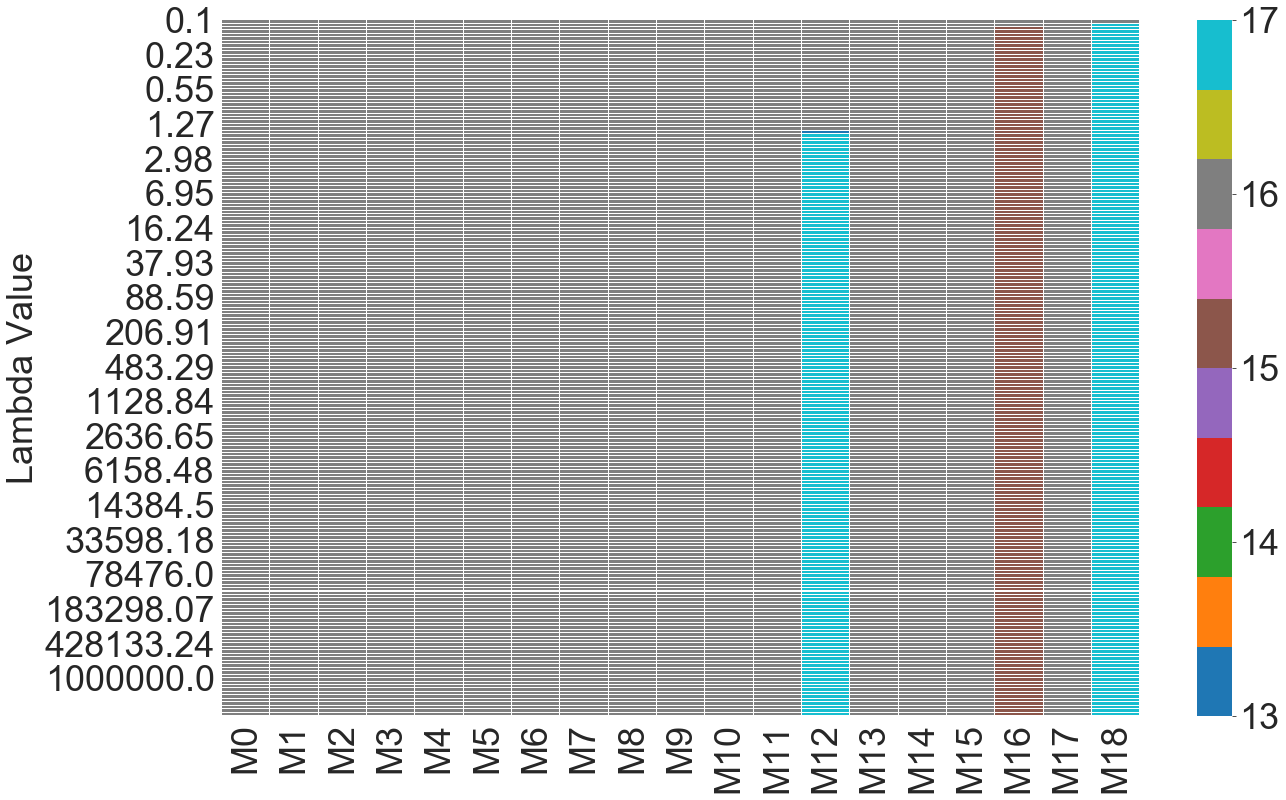

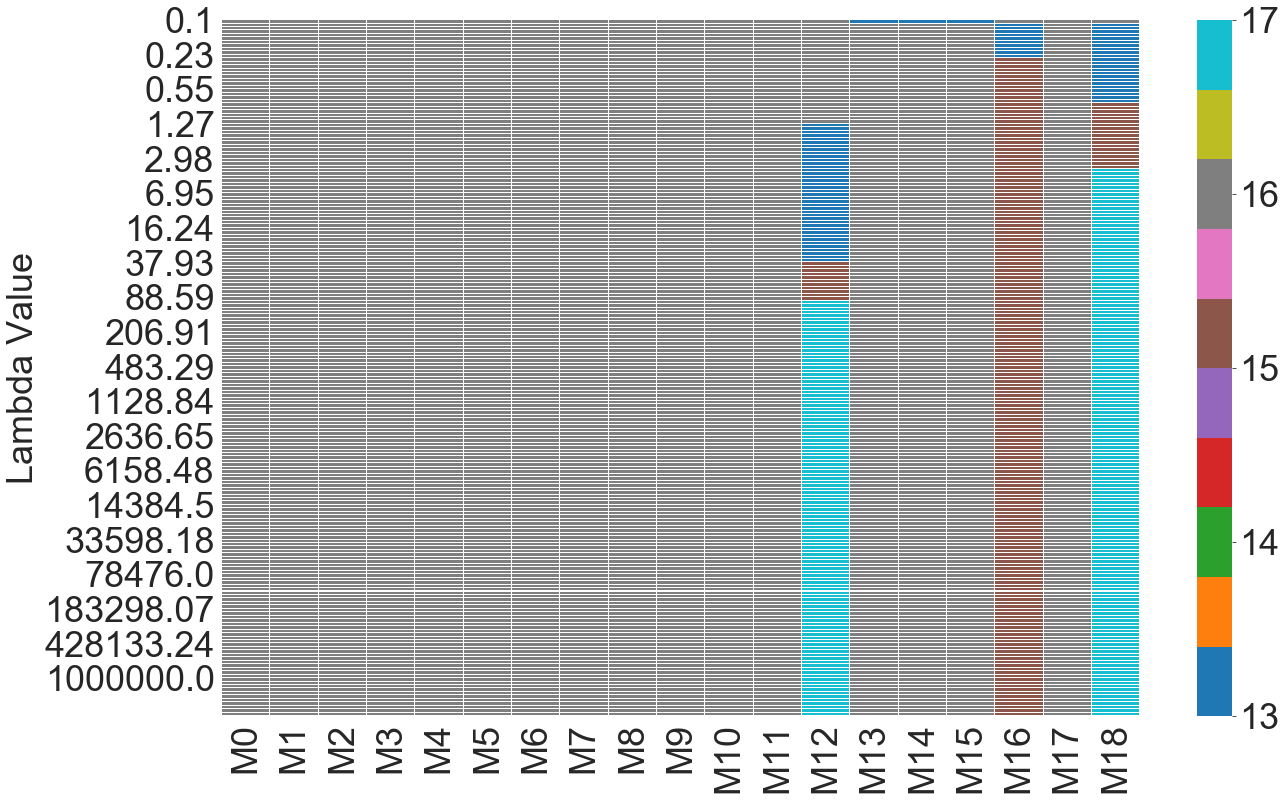

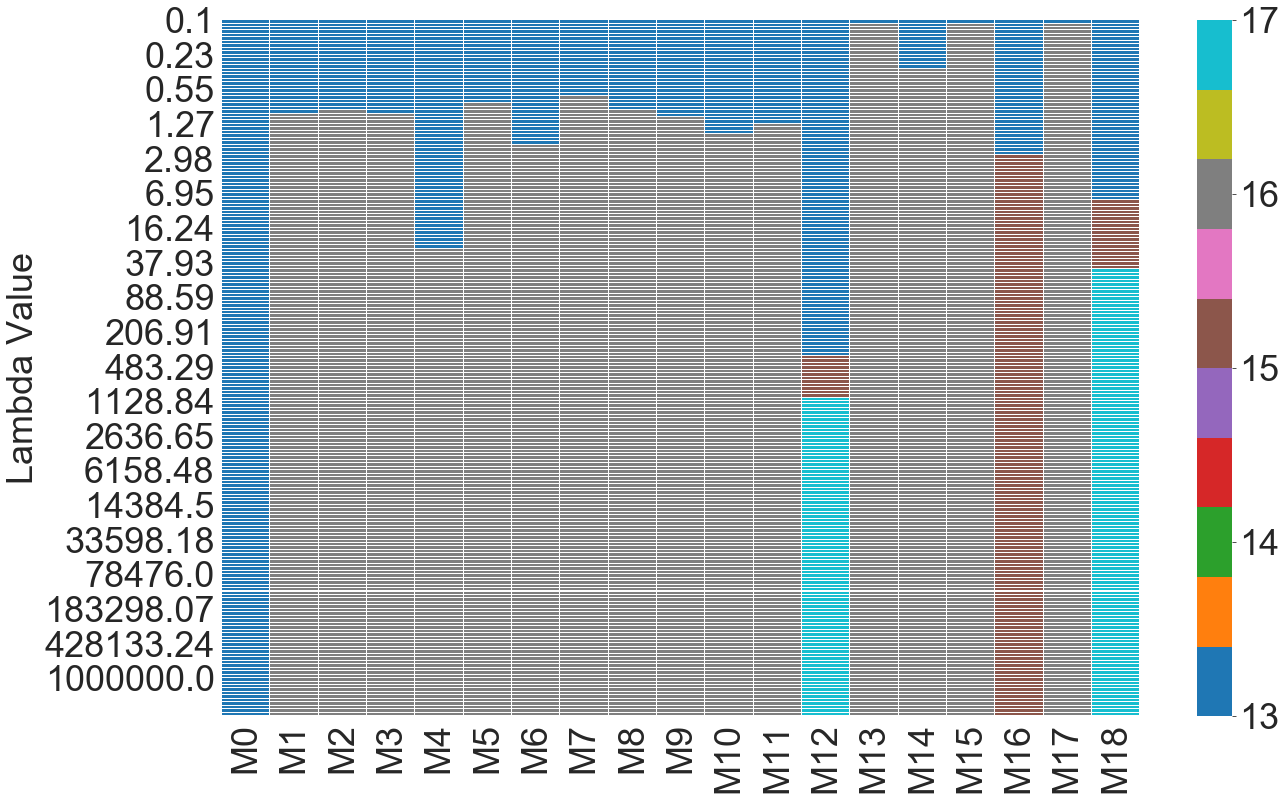

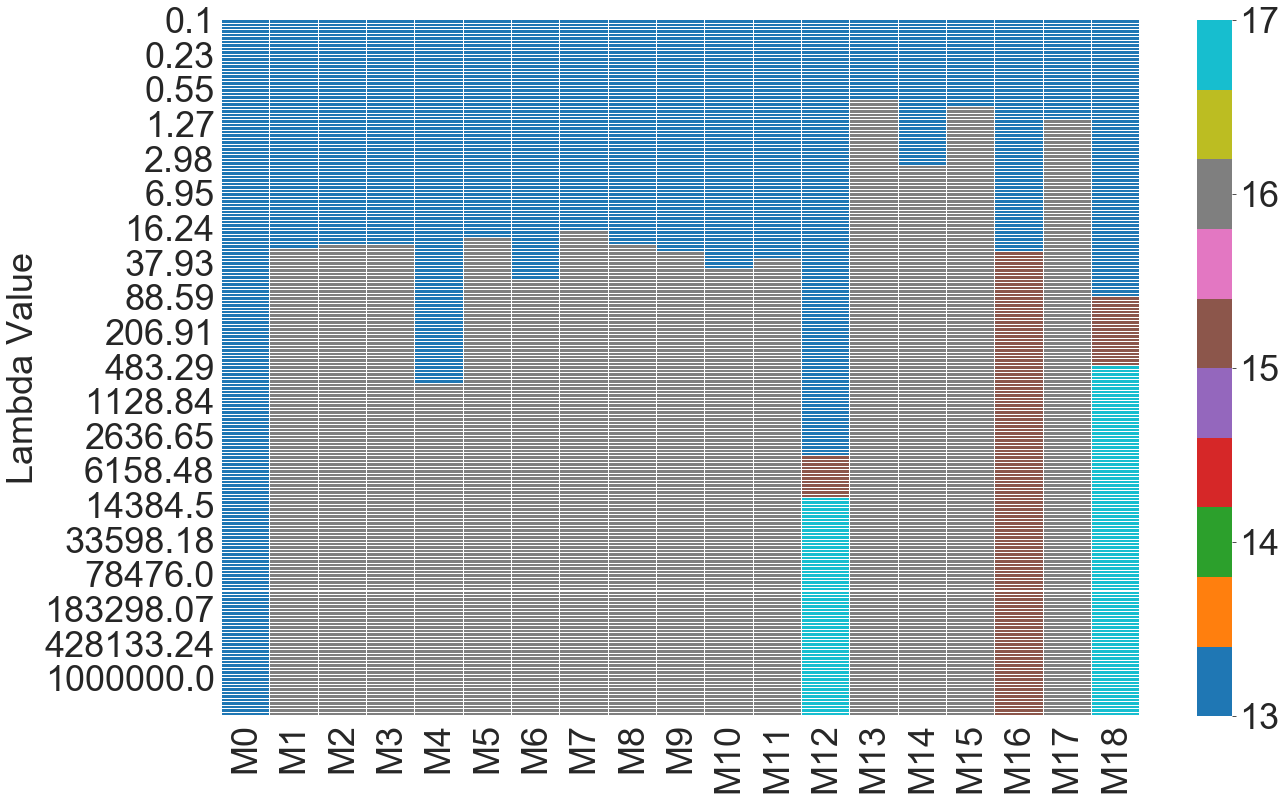

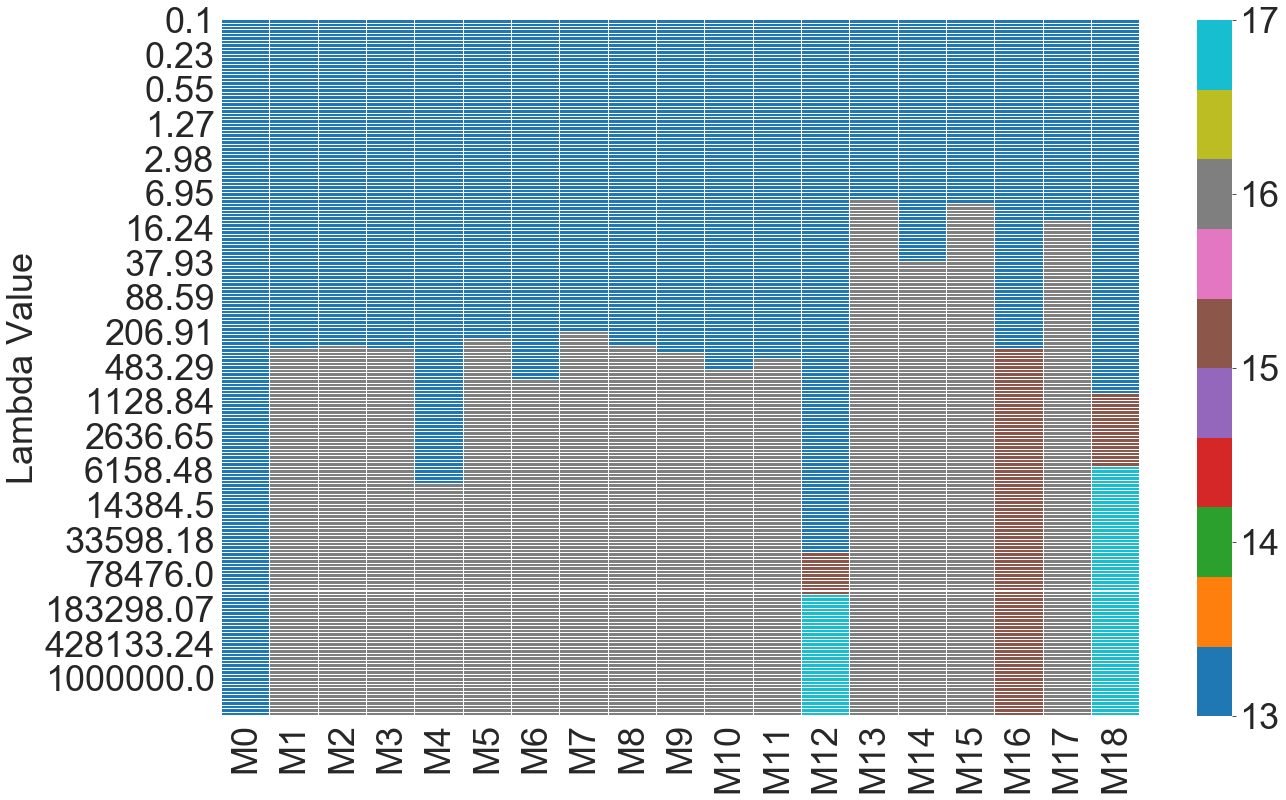

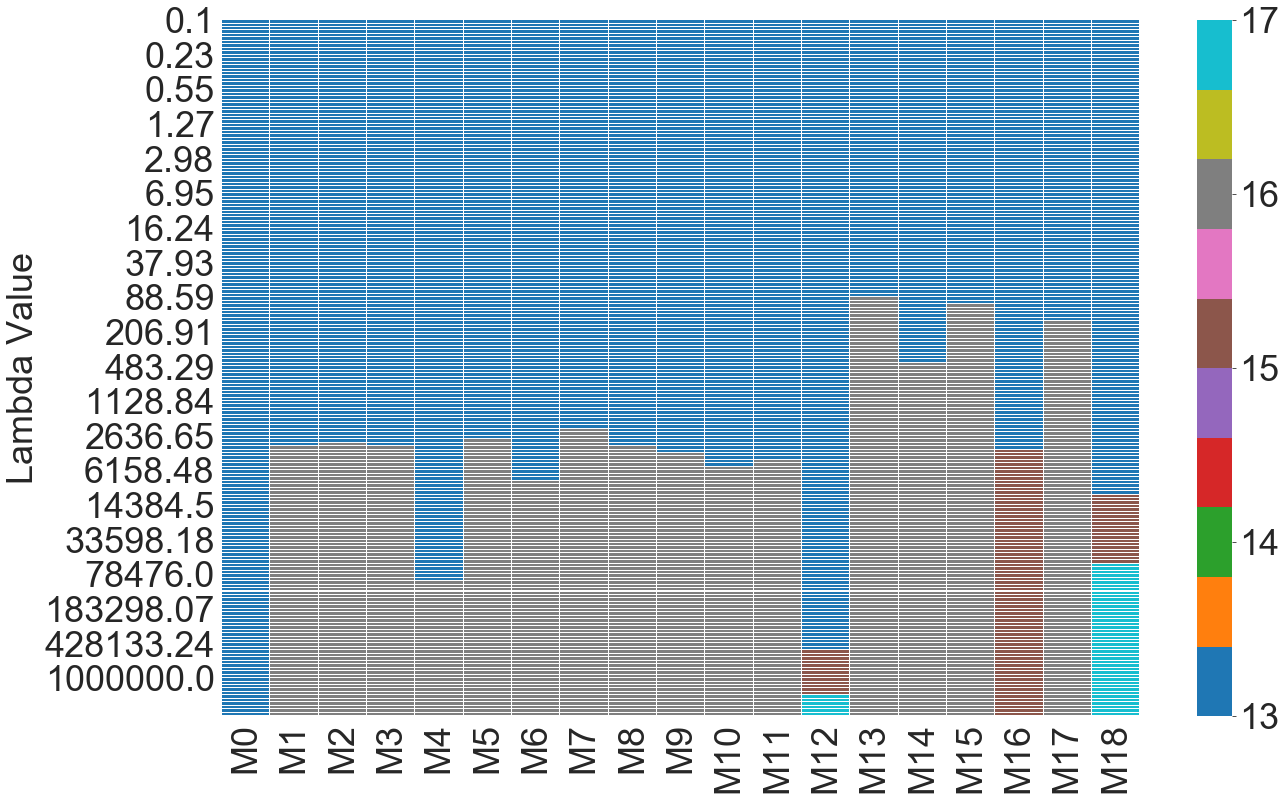

In [58]:
for eta_val in [0, 10, 100, 1e3, 1e4, 1e5]: 

    savepath_str = 'visualizations/alta-bates/replacement-figs/alta_bates_replacements_eta_{}.png'.format(eta_val)
    lambda_range = np.hstack(([0.0], np.logspace(-1, 6, 200)))
    
    optimal_opening_matrix = get_alta_bates_replacement_matrix(one_fac_replace_ab_no_replacement_df, 
                                                               lambda_range, eta_val)
    # Create figure 
    ax = sns.heatmap(optimal_opening_matrix, cmap='tab10', linewidth=0.01)
    
    cbar = ax.collections[0].colorbar
    cbar.set_ticks([13, 14, 15, 16, 17])

    plt.yticks(np.arange(0, 200, 10), np.round(np.logspace(-1, 6, 20), 2), rotation=0);
    metric_names = ['M{}'.format(i + 1) for i in range(18)]
    plt.ylabel('Lambda Value')
    plt.xticks(np.arange(1 + len(metric_names)) + 0.5, ['M0'] + metric_names, rotation=90);
    plt.tight_layout();
    plt.savefig(savepath_str)
    plt.pause(0.01)

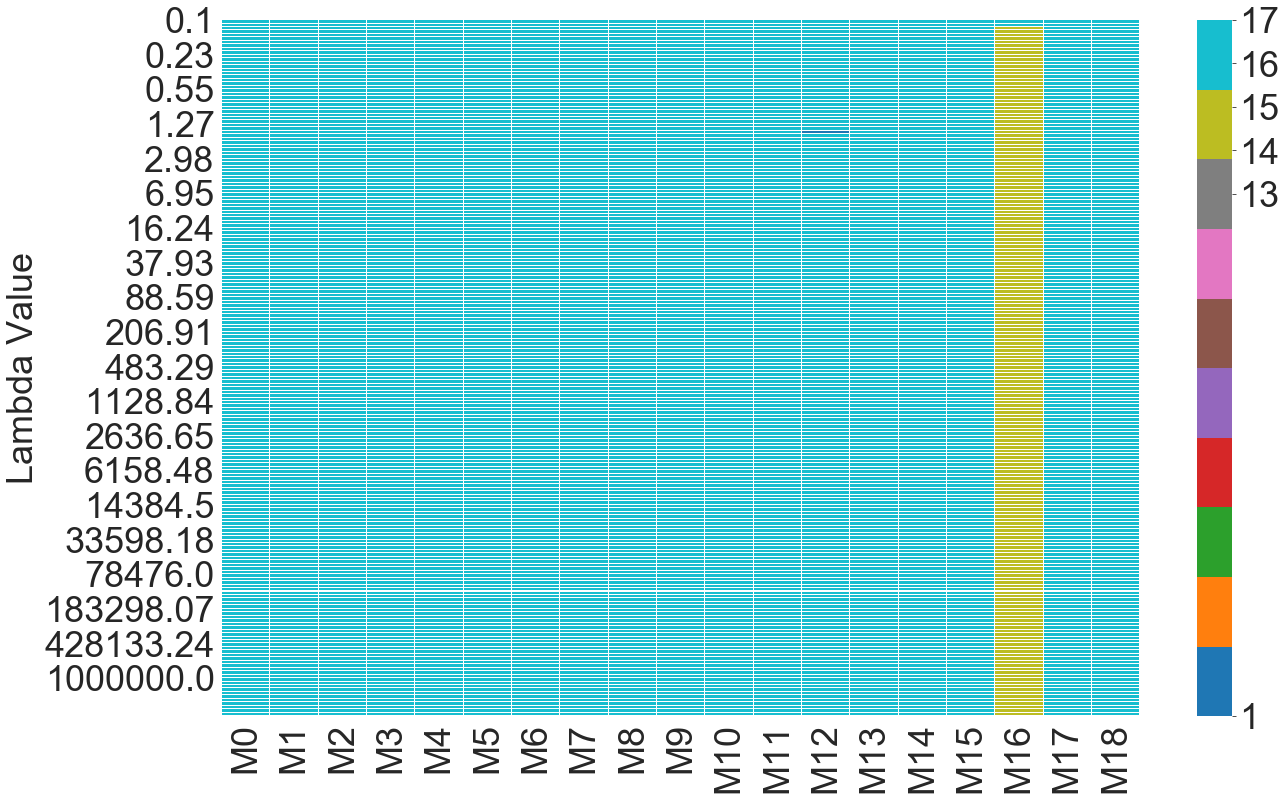

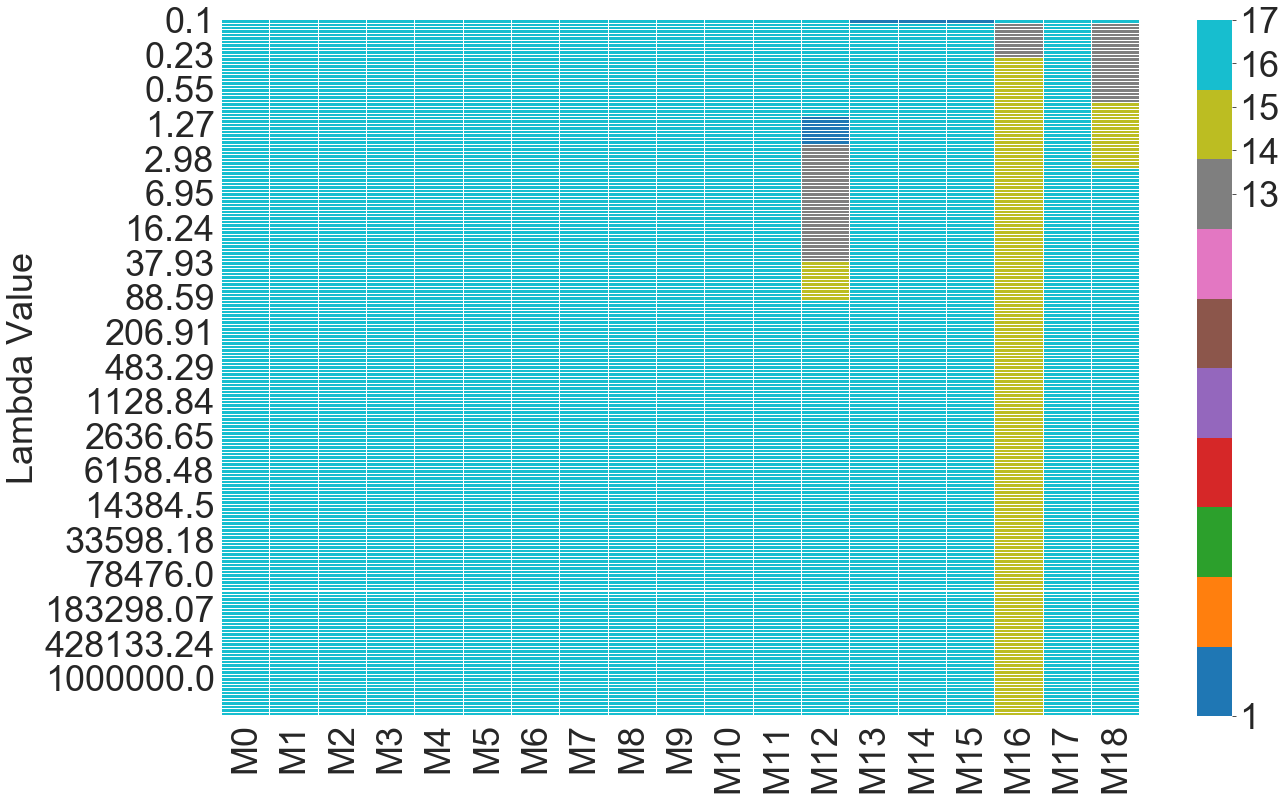

KeyboardInterrupt: 

In [59]:
for eta_val in [0, 10, 100, 1e3, 1e4, 1e5]: 
    savepath_str = 'visualizations/alta-bates/replacement-with-ab-option/alta_bates_replacements_eta_{}.png'.format(eta_val)
    lambda_range = np.hstack(([0.0], np.logspace(-1, 6, 200)))
    
    optimal_opening_matrix = get_alta_bates_replacement_matrix(one_fac_replace_ab_df, 
                                                               lambda_range, eta_val)
    # Create figure 
    ax = sns.heatmap(optimal_opening_matrix, cmap='tab10', linewidth=0.01)
    
    cbar = ax.collections[0].colorbar
    cbar.set_ticks([1, 13, 14, 15, 16, 17])
    
    plt.yticks(np.arange(0, 200, 10), np.round(np.logspace(-1, 6, 20), 2), rotation=0);
    metric_names = ['M{}'.format(i + 1) for i in range(18)]
    plt.ylabel('Lambda Value')
    plt.xticks(np.arange(1 + len(metric_names)) + 0.5, ['M0'] + metric_names, rotation=90);
    plt.tight_layout();
    plt.savefig(savepath_str)
    plt.pause(0.01)

In [158]:
get_alta_bates_replacement_matrix(one_fac_replace_ab_no_replacement_df, lambda_range, 1e4)

array([[13., 13., 13., ..., 13., 13., 13.],
       [13., 13., 13., ..., 13., 13., 13.],
       [13., 13., 13., ..., 13., 13., 13.],
       ...,
       [13., 16., 16., ..., 16., 16., 16.],
       [13., 16., 16., ..., 16., 16., 16.],
       [13., 16., 16., ..., 16., 16., 16.]])

## How Much to Rescale Facility 17

Sutter Health plans to expand the capacity of another hospital of theirs (facility 17 in our numbering) to deal with the closure of Alta Bates. We have dataframes which simulate what this would look like for various expansion levels at facility 17. How much is enough to make facility 17 the optimal one to open? Let's see. 

In [60]:
os.listdir('all-data/allocation-dfs/alta-bates-replacements-rescaled-beds/')

['.DS_Store',
 'one_fac_replace_alta_bates_no_replacement_fac_17_1.1_rescale.csv',
 'one_fac_replace_alta_bates_no_replacement_fac_17_1.2_rescale.csv',
 'one_fac_replace_alta_bates_no_replacement_fac_17_1.3_rescale.csv',
 'one_fac_replace_alta_bates_no_replacement_fac_17_1.4_rescale.csv',
 'one_fac_replace_alta_bates_no_replacement_fac_17_1.5_rescale.csv',
 'one_fac_replace_alta_bates_no_replacement_fac_17_1.6_rescale.csv',
 'one_fac_replace_alta_bates_no_replacement_fac_17_1.7_rescale.csv',
 'one_fac_replace_alta_bates_no_replacement_fac_17_1.8_rescale.csv',
 'one_fac_replace_alta_bates_no_replacement_fac_17_1.9_rescale.csv',
 'one_fac_replace_alta_bates_no_replacement_fac_17_10.0_rescale.csv',
 'one_fac_replace_alta_bates_no_replacement_fac_17_100_rescale.csv',
 'one_fac_replace_alta_bates_no_replacement_fac_17_105_rescale.csv',
 'one_fac_replace_alta_bates_no_replacement_fac_17_110_rescale.csv',
 'one_fac_replace_alta_bates_no_replacement_fac_17_115_rescale.csv',
 'one_fac_replace_a

In [63]:
eta_val = 1000.0

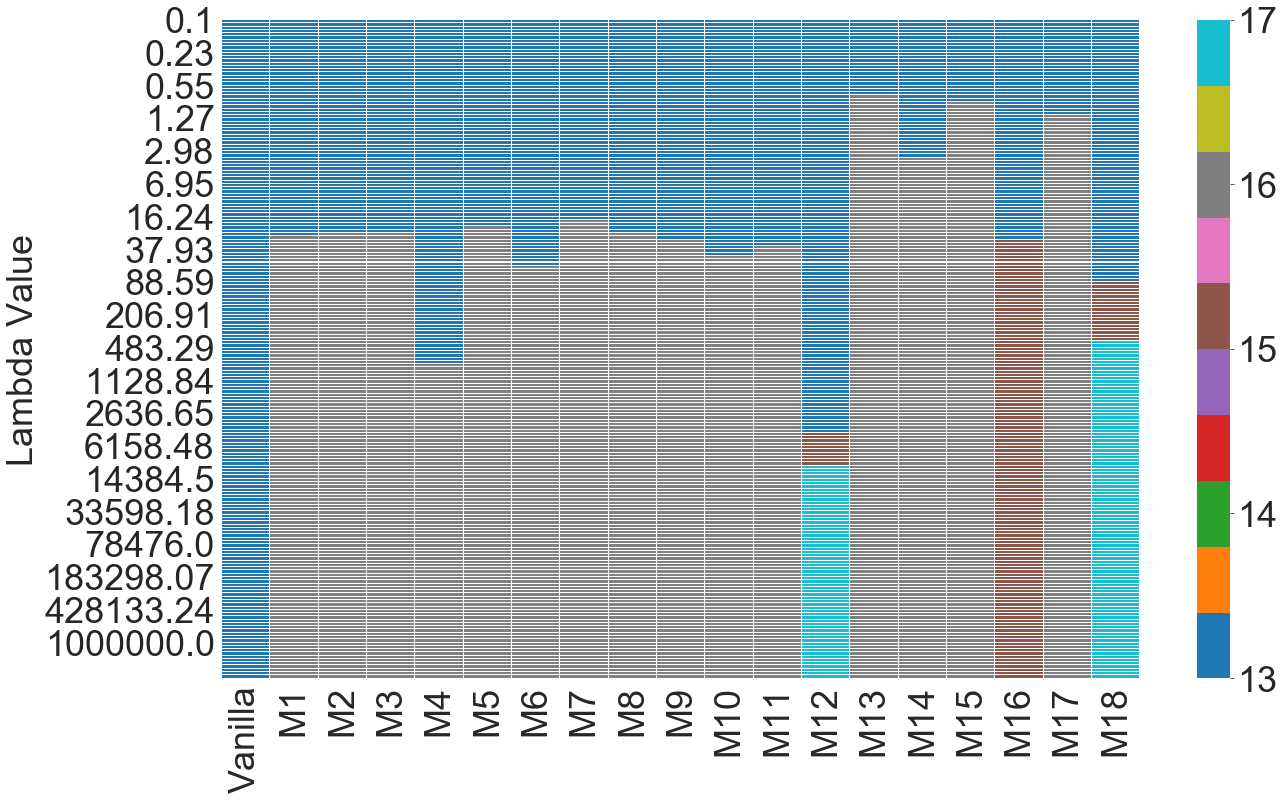

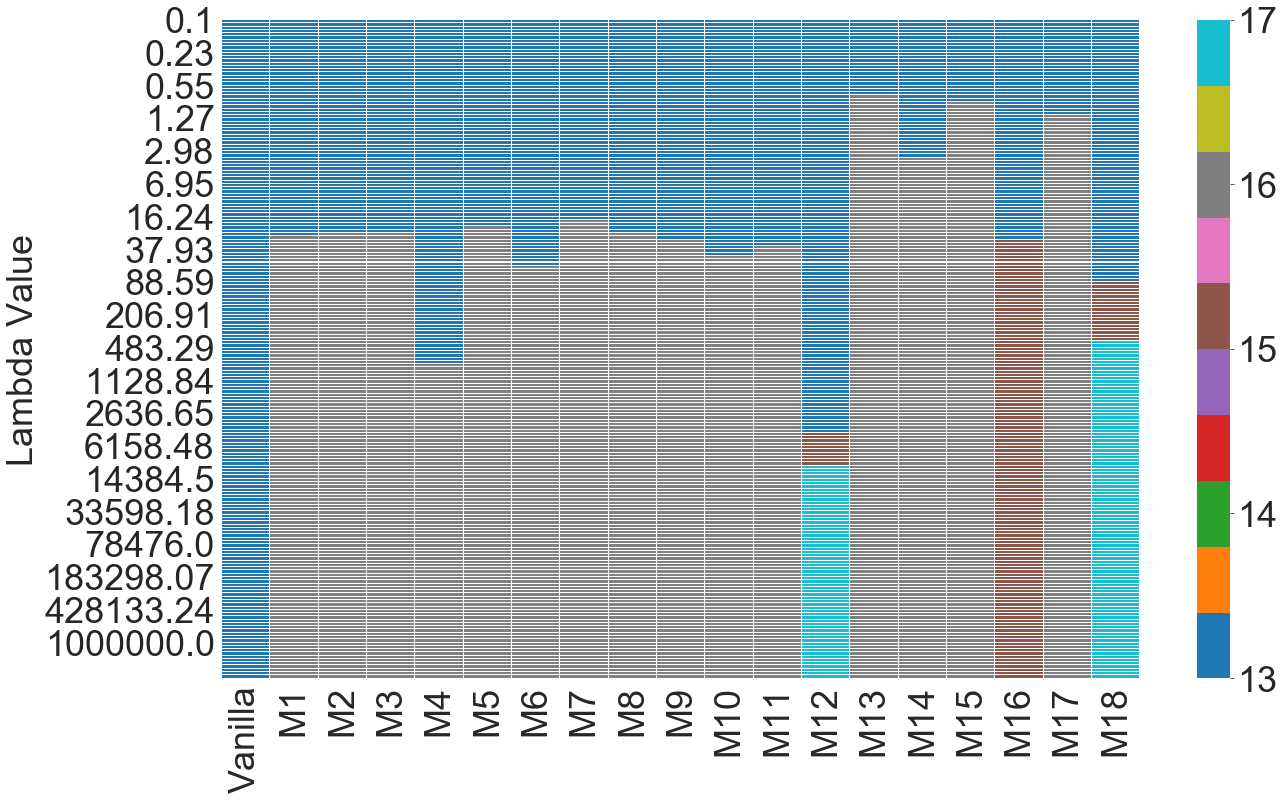

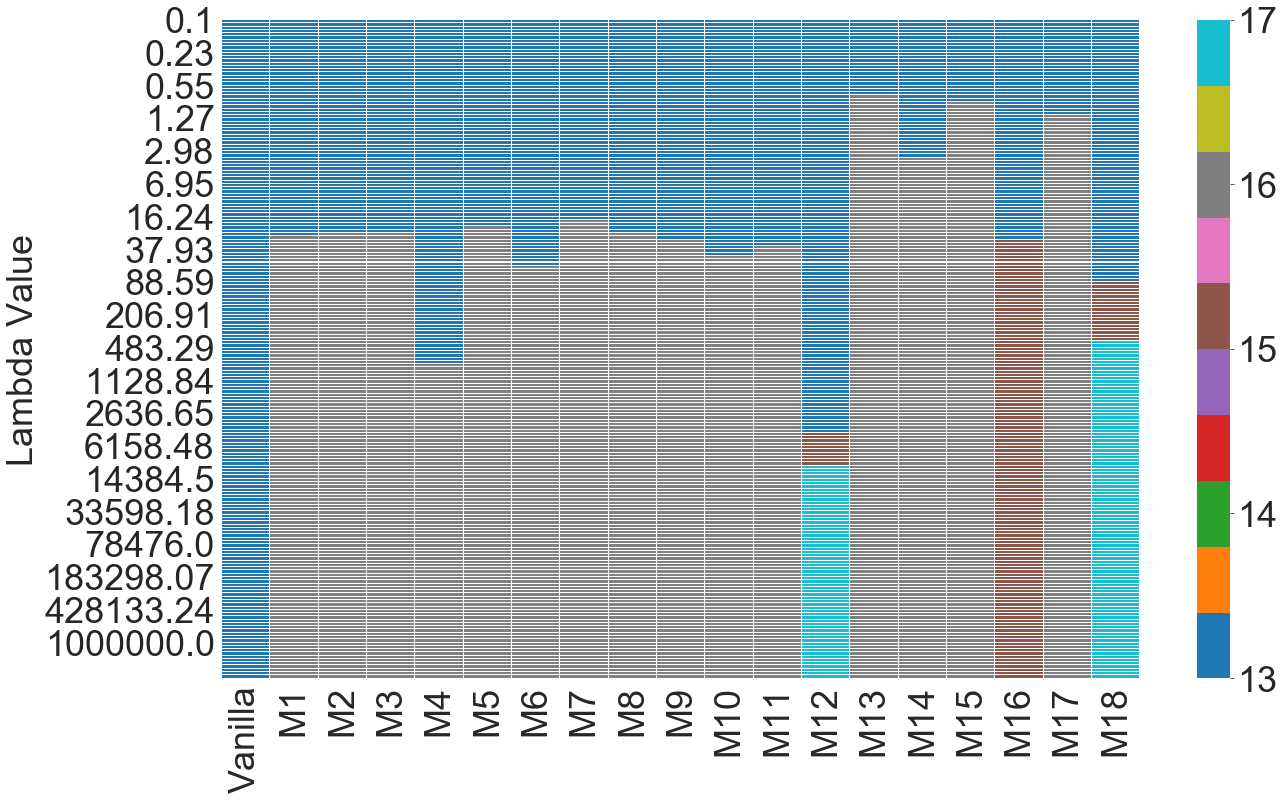

In [65]:
#[2.0, 3.0, 4.0, 5.0 7.0, 9.0, 20, 30, 40, 50, 100, 150, 200]
for scale_fac in [2.0, 20, 200]: 
    scaling_fac = np.round(scale_fac, 2)
    lambda_range = np.hstack(([0.0], np.logspace(-1, 6, 200)))
    
    filepath = 'all-data/allocation-dfs/alta-bates-replacements-rescaled-beds/'
    filepath += 'one_fac_replace_alta_bates_no_replacement_fac_17_{}_rescale.csv'.format(scaling_fac)
    
    allocation_df = pd.read_csv(filepath)
    
    optimal_opening_matrix = get_alta_bates_replacement_matrix(allocation_df, 
                                                               lambda_range, eta_val)
    # Create figure 
    ax = sns.heatmap(optimal_opening_matrix, cmap='tab10', linewidth=0.01)
    
    cbar = ax.collections[0].colorbar
    cbar.set_ticks([13, 14, 15, 16, 17])
    
    plt.yticks(np.arange(0, 200, 10), np.round(np.logspace(-1, 6, 20), 2), rotation=0);
    metric_names = ['M{}'.format(i + 1) for i in range(18)]
    plt.ylabel('Lambda Value')
    plt.xticks(np.arange(1 + len(metric_names)) + 0.5, ['Vanilla'] + metric_names, rotation=90);
    plt.tight_layout();
    #     plt.savefig(savepath_str)
    plt.pause(0.01)

635247.0087431695

In [66]:
capacity_devs = []
for scale_fac in [2.0, 3.0, 5.0, 7.0, 9.0, 20, 30, 40, 50, 100, 150, 200]: 
    scaling_fac = np.round(scale_fac, 2)
    
    filepath = 'all-data/allocation-dfs/alta-bates-replacements-rescaled-beds/'
    filepath += 'one_fac_replace_alta_bates_no_replacement_fac_17_{}_rescale.csv'.format(scaling_fac)
    
    allocation_df = pd.read_csv(filepath)
    capac_excess = allocation_df.iloc[-1]['Capacity_Excess']
    capacity_devs.append(capac_excess)

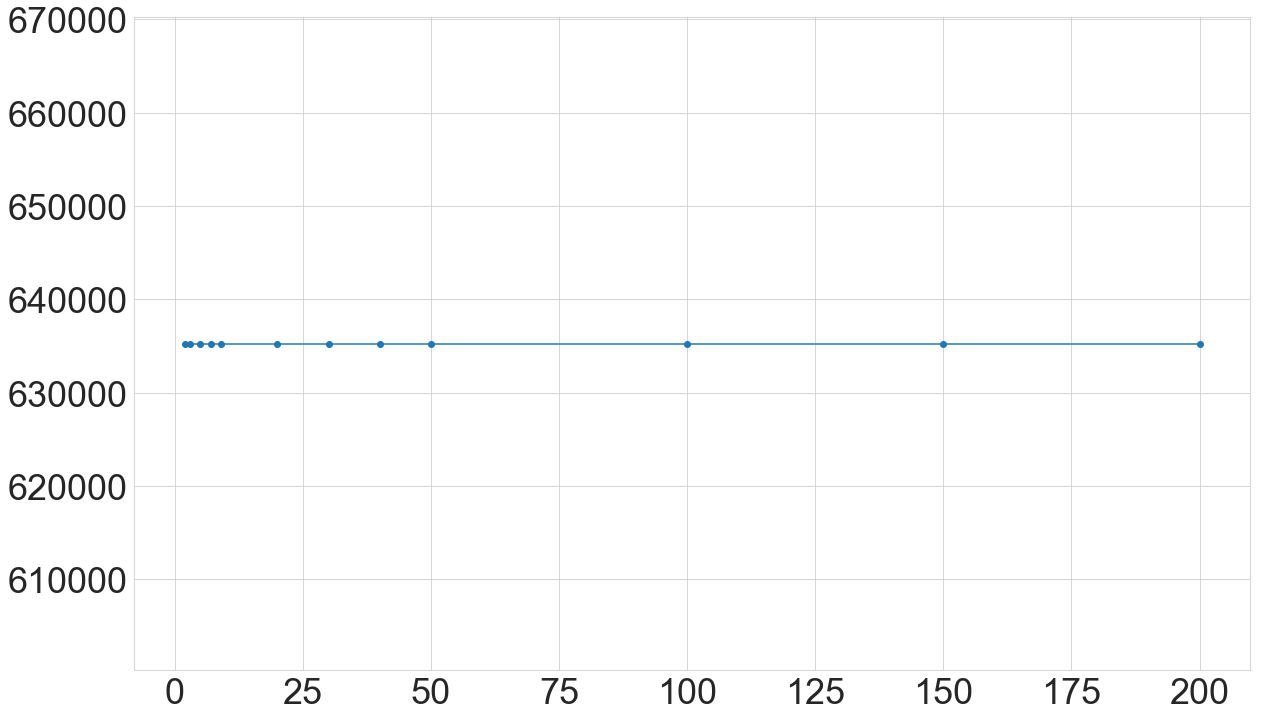

In [68]:
plt.plot([2.0, 3.0, 5.0, 7.0, 9.0, 20, 30, 40, 50, 100, 150, 200], capacity_devs, marker='o')